Peter Meleney  
03/28/16   
v0.1.15 
  
<h1 align="center">  Predicting Output from Wind Farms in the California Independent System Operator (CAISO) Grid </h1>

In [13]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pylab
import glob
import time
import datetime

from __future__ import division
from IPython.display import Image
from patsy import dmatrices, dmatrix

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import PredefinedSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

%matplotlib inline

##1.1 CAISO Generation Data

In [14]:
# I will fill in the capacity of the CAISO wind system will be done by hand.  This dataframe is NaN by default.

windCap_CAISO = pd.DataFrame(45072*[np.NaN], 
                             index = pd.date_range(start = pd.to_datetime('2010-04-10 00:00:00'), 
                                                   end = pd.to_datetime('2015-05-31 23:00:00'), freq = 'H'), 
                             columns = ['CAISO_WindCapacity'])

In [15]:
# I calculated the CAISO system capacity by hand. The raw data used in this
# calculation is available in MasterControlAreaGeneratingCapabilityList.xls.
# Days in which new wind farms come oneline are excluded from this dataframe, and
# will be excluded from the model, because I don't know what time of day they were activated.

windCap_CAISO[pd.to_datetime('2010-04-10'):pd.to_datetime('2010-11-18 23:00:00')] = 2497.58
windCap_CAISO[pd.to_datetime('2010-11-20'):pd.to_datetime('2010-12-28 23:00:00')] = 2581.58
windCap_CAISO[pd.to_datetime('2010-12-30'):pd.to_datetime('2011-01-24 23:00:00')] = 2881.58
windCap_CAISO[pd.to_datetime('2011-01-26'):pd.to_datetime('2011-02-11 23:00:00')] = 2918.38
windCap_CAISO[pd.to_datetime('2011-02-13'):pd.to_datetime('2011-02-20 23:00:00')] = 3068.38
windCap_CAISO[pd.to_datetime('2011-02-22'):pd.to_datetime('2011-03-11 23:00:00')] = 3090.88
windCap_CAISO[pd.to_datetime('2011-03-13'):pd.to_datetime('2011-04-20 23:00:00')] = 3192.88
windCap_CAISO[pd.to_datetime('2011-04-22'):pd.to_datetime('2011-12-21 23:00:00')] = 3360.88
windCap_CAISO[pd.to_datetime('2011-12-23'):pd.to_datetime('2012-01-27 23:00:00')] = 3463.38
windCap_CAISO[pd.to_datetime('2012-02-02'):pd.to_datetime('2012-02-22 23:00:00')] = 3811.58
windCap_CAISO[pd.to_datetime('2012-02-24'):pd.to_datetime('2012-03-28 23:00:00')] = 3860.58
windCap_CAISO[pd.to_datetime('2012-03-30'):pd.to_datetime('2012-04-17 23:00:00')] = 3962.58
windCap_CAISO[pd.to_datetime('2012-04-19'):pd.to_datetime('2012-05-08 23:00:00')] = 4090.38
windCap_CAISO[pd.to_datetime('2012-05-10'):pd.to_datetime('2012-09-11 23:00:00')] = 4240.38
windCap_CAISO[pd.to_datetime('2012-09-13'):pd.to_datetime('2012-12-06 23:00:00')] = 4380.38
windCap_CAISO[pd.to_datetime('2013-01-02'):pd.to_datetime('2013-05-16 23:00:00')] = 5206.38
windCap_CAISO[pd.to_datetime('2013-05-18'):pd.to_datetime('2013-07-29 23:00:00')] = 5226.33
windCap_CAISO[pd.to_datetime('2013-07-31'):pd.to_datetime('2014-12-31 23:00:00')] = 5491.33
windCap_CAISO[pd.to_datetime('2015-01-02'):pd.to_datetime('2015-01-11 23:00:00')] = 5719.33
windCap_CAISO[pd.to_datetime('2015-01-13'):pd.to_datetime('2015-01-25 23:00:00')] = 5818.33
windCap_CAISO[pd.to_datetime('2015-01-27'):pd.to_datetime('2015-05-31 23:00:00')] = 5829.53

In [16]:
#List of all CAISO renewables report names
CAISO_fileList = glob.glob('data/rawData/CAISO_renewablesWatch/*.txt')

In [17]:
#Count of the length of file_list, and the expected length of the final DataFrame

print 'The length of the file list is : ', len(CAISO_fileList)
print 'The expected length of the DataFrame is: ' + str(24*len(CAISO_fileList))

The length of the file list is :  1865
The expected length of the DataFrame is: 44760


In [18]:
# This is a list of file that the data import loop skips.  
# I'm not sure how CAISO dealt with daylight savings time.  Daylight savings days are skipped

CAISO_skipList = ['data/rawData/CAISO_renewablesWatch/20100806_DailyRenewablesWatch.txt', #Data Corrupt [No data for calculation]
                  'data/rawData/CAISO_renewablesWatch/20101029_DailyRenewablesWatch.txt', #Contains unusable data
                  'data/rawData/CAISO_renewablesWatch/20101107_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20110313_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20110630_DailyRenewablesWatch.txt', #Data Corrupt [Connection to the server lost]
                  'data/rawData/CAISO_renewablesWatch/20110716_DailyRenewablesWatch.txt', #Data corrupt #NAME?
                  'data/rawData/CAISO_renewablesWatch/20111106_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20120228_DailyRenewablesWatch.txt', #dtype float, normally int
                  'data/rawData/CAISO_renewablesWatch/20120311_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20130310_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20131103_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20140309_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20141102_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20150308_DailyRenewablesWatch.txt'] #daylight savings


In [19]:
raw_CAISO = pd.DataFrame([], columns = ['WindTotal'])

for f in CAISO_fileList:
    if f in CAISO_skipList:
        continue
        
    raw_CAISOHolder = pd.read_csv(f, sep = None, engine = 'python', header = True) #import each file
    
    
    #pd.read_csv sometimes improperly assigns column names.  How this occurs changes based on the number
    #of columns in the .txt file.  I handle the issue by directly naming the columns here.
    if raw_CAISOHolder.shape[1] == 14:
        raw_CAISOHolder.columns = ['BLANK', 'Hour','BLANK','Geothermal','BLANK', 'Biomass','BLANK', 'Biogas', 
                'BLANK','Small Hydro','BLANK', 'WindTotal', 'BLANK','SolarPV' ]
    elif raw_CAISOHolder.shape[1] == 16:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal' ]
    elif raw_CAISOHolder.shape[1] == 17:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','NONE','SolarThermal']
    elif raw_CAISOHolder.shape[1] == 18:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal','NONE','NONE' ]
    
    
    raw_CAISOHolder = raw_CAISOHolder.iloc[0:24,:] #Select rows that contain Wind data
    raw_CAISOHolder.Hour = raw_CAISOHolder.Hour.astype(int) - 1 #CAISO hours are 1-indexed, change to 0-index to match datetime
    raw_CAISOHolder['INDEX'] = f[35:43] + '_' + raw_CAISOHolder.Hour.astype(str) #Extract date from filename
    raw_CAISOHolder = raw_CAISOHolder.loc[:,('INDEX', 'WindTotal')] #Remove irrelevant columns
    raw_CAISOHolder.index = pd.to_datetime(raw_CAISOHolder.INDEX[0:24], format = "%Y%m%d_%H") #Reindex to datetime dtype
    raw_CAISOHolder = raw_CAISOHolder.drop(['INDEX'], axis = 1) #Drop INDEX column, no longer needed
    
    raw_CAISO = pd.concat([raw_CAISO, raw_CAISOHolder], axis = 0) #build rawData from each file iteratively

raw_CAISO.columns = ['WindOutput_MW']
raw_CAISO.WindOutput_MW = raw_CAISO.WindOutput_MW.astype(int)

In [20]:
#Several hours indicate that power was consumed by wind farms.  I leave thses data in the model, they don't
#appear to affect the outcome much, but it is good to be aware that the power flow is not always positive
#in the training set.

raw_CAISO.loc[raw_CAISO.WindOutput_MW < 0]

,WindOutput_MW
2010-04-25 13:00:00,-2
2010-07-15 10:00:00,-15
2010-07-15 11:00:00,-21
2010-07-15 12:00:00,-12
2010-07-15 13:00:00,-7
2010-12-02 05:00:00,-1
2010-12-02 07:00:00,-1
2010-12-02 08:00:00,-2


##1.2 NOAA Weather Data

In [39]:
#Lists all the files in the data folder

file_list_CAMPO = glob.glob('data/rawData/NOAA_rawWeatherStationData/CAMPO/*.html')
file_list_Livermore = glob.glob('data/rawData/NOAA_rawWeatherStationData/LivermoreMuniApt/*.html')
file_list_PSIA = glob.glob('data/rawData/NOAA_rawWeatherStationData/PalmSpringsIntlApt/*.html')
file_list_PortChicago = glob.glob('data/rawData/NOAA_rawWeatherStationData/PortChicago/*.html')
file_list_Redding = glob.glob('data/rawData/NOAA_rawWeatherStationData/ReddingMuniApt/*.html')
file_list_Tehachapi = glob.glob('data/rawData/NOAA_rawWeatherStationData/TehachapiMunicipal/*.html')

In [40]:
#All file lists should have 62 elements.  One for each month 4/2010 - 5/2015 inclusive.

[len(file_list_CAMPO),
len(file_list_Livermore),
len(file_list_PSIA),
len(file_list_PortChicago),
len(file_list_Redding),
len(file_list_Tehachapi)]

[62, 62, 62, 62, 62, 62]

In [41]:
#Programatically load NOAA station observation data into pd.DataFrame with appropriately
#named columns.  These DataFrames will be concatinated later, so column names should be
#unique.

#file_list is a list of files to be loaded, NOAAStation is a str to be concatinated 
#with the column titles.  Returns a pd.DataFrame.

def loadNOAAData(file_list, NOAAStation):
    
    DataHolder = pd.DataFrame([])
    
    #Load HTML file into DataHolder
    for f in file_list:
        data_raw = pd.read_html(f)
        data_raw = pd.DataFrame(data_raw[1])
        data_raw.columns = data_raw.iloc[0,:]
        data_raw = data_raw.iloc[2:,:]
        data_raw = data_raw[['YR--MODAHRMN','DIR',
                        'SPD','GUS','TEMP','DEWP','SLP','STP']]
        DataHolder = pd.concat([DataHolder, data_raw], axis = 0)
    
    #Identify NAN and non-sensical data entries
    DataHolder.SPD = DataHolder.SPD.replace('***',0) #numerical
    DataHolder.GUS = DataHolder.GUS.replace('***',0) #numerical
    DataHolder.DIR = DataHolder.DIR.replace(['***','990'],['No_Wind','DIR_Not_Reported']) #class
    DataHolder.STP = DataHolder.STP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.SLP = DataHolder.SLP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.TEMP = DataHolder.TEMP.replace('****', np.nan) #numerical
    DataHolder.DEWP = DataHolder.DEWP.replace('****', np.nan) #numerical
    
    #Change dtypes to those appropriate for modeling
    DataHolder['YR--MODAHRMN'] = pd.to_datetime(DataHolder['YR--MODAHRMN'], format = '%Y%m%d%H%M')
    DataHolder.SPD = DataHolder.SPD.astype(int)
    DataHolder.GUS = DataHolder.GUS.astype(int)
    DataHolder.DIR = DataHolder.DIR.astype(str)
    DataHolder.STP = DataHolder.STP.astype(float)
    DataHolder.SLP = DataHolder.SLP.astype(float)
    DataHolder.TEMP = DataHolder.TEMP.astype(float)
    DataHolder.DEWP = DataHolder.DEWP.astype(float)
    
    #Rename columns to unique headdings
    DataHolder.columns = [NOAAStation + '_ActualTime',NOAAStation + '_Wind_Dir',
                          NOAAStation + '_Wind_Spd',NOAAStation + '_Gust_Spd',
                          NOAAStation + '_Temp',NOAAStation + '_Dew_Pt',
                          NOAAStation + '_SLP',NOAAStation + '_StaP']

    print 'loadNOAAData(' + NOAAStation + ') Completed.'
    return DataHolder

In [42]:
#This cell loads all NOAA station data, it takes a while to run. (~260 sec on my laptop)

Start = time.time()

NOAA_Data_CAMPO = loadNOAAData(file_list_CAMPO, 'CAMPO')
NOAA_Data_Livermore = loadNOAAData(file_list_Livermore, 'Livermore')
NOAA_Data_PSIA = loadNOAAData(file_list_PSIA, 'PSIA')
NOAA_Data_Redding = loadNOAAData(file_list_Redding, 'Redding')
NOAA_Data_Tehachapi = loadNOAAData(file_list_Tehachapi, 'Tehachapi')
NOAA_Data_PortChicago = loadNOAAData(file_list_PortChicago, 'PortChicago')

print ""
print "COMPLETED LOADING ALL DATA"
print "Elapsed time = " + str(int(time.time()-Start)) + " seconds."

loadNOAAData(CAMPO) Completed.
loadNOAAData(Livermore) Completed.
loadNOAAData(PSIA) Completed.
loadNOAAData(Redding) Completed.
loadNOAAData(Tehachapi) Completed.
loadNOAAData(PortChicago) Completed.

COMPLETED LOADING ALL DATA
Elapsed time = 241 seconds.


In [43]:
#Reindex NOAA_dataframes to Acutal time in Timestamp format.

NOAA_Data_CAMPO.index = NOAA_Data_CAMPO.CAMPO_ActualTime
NOAA_Data_Livermore.index = NOAA_Data_Livermore.Livermore_ActualTime 
NOAA_Data_PSIA.index = NOAA_Data_PSIA.PSIA_ActualTime 
NOAA_Data_Redding.index = NOAA_Data_Redding.Redding_ActualTime 
NOAA_Data_Tehachapi.index = NOAA_Data_Tehachapi.Tehachapi_ActualTime 
NOAA_Data_PortChicago.index = NOAA_Data_PortChicago.PortChicago_ActualTime 

In [44]:
#Extract minute from the index - this will be used to extract the proper observations later.

NOAA_Data_CAMPO['Minute'] = NOAA_Data_CAMPO.index.minute
NOAA_Data_Livermore['Minute'] = NOAA_Data_Livermore.index.minute
NOAA_Data_PSIA['Minute'] = NOAA_Data_PSIA.index.minute
NOAA_Data_Redding['Minute'] = NOAA_Data_Redding.index.minute
NOAA_Data_Tehachapi['Minute'] = NOAA_Data_Tehachapi.index.minute
NOAA_Data_PortChicago['Minute'] = NOAA_Data_PortChicago.index.minute

In [45]:
NOAA_Data_CAMPO.head()

,CAMPO_ActualTime,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,Minute
CAMPO_ActualTime,,,,,,,,,
2010-04-01 00:52:00,2010-04-01 00:52:00,220,15,0,48,32,1008.7,917.9,52
2010-04-01 01:52:00,2010-04-01 01:52:00,240,14,0,46,38,1009.0,918.2,52
2010-04-01 02:52:00,2010-04-01 02:52:00,240,11,0,44,38,1009.3,918.5,52
2010-04-01 03:52:00,2010-04-01 03:52:00,240,11,0,43,40,1009.9,918.8,52
2010-04-01 04:52:00,2010-04-01 04:52:00,230,13,18,43,40,1010.5,919.4,52


In [46]:
#Round the index of each NOAA dataframe to the nearest hour
ns1hr=60*60*1000000000   # One hour in nanoseconds 

NOAA_Data_CAMPO.index = pd.DatetimeIndex(((NOAA_Data_CAMPO.CAMPO_ActualTime.astype(np.int64) // ns1hr) * ns1hr))
NOAA_Data_Livermore.index = pd.DatetimeIndex(((NOAA_Data_Livermore.Livermore_ActualTime.astype(np.int64) // ns1hr) * ns1hr))
NOAA_Data_PSIA.index = pd.DatetimeIndex(((NOAA_Data_PSIA.PSIA_ActualTime.astype(np.int64) // ns1hr) * ns1hr))
NOAA_Data_Redding.index = pd.DatetimeIndex(((NOAA_Data_Redding.Redding_ActualTime.astype(np.int64) // ns1hr) * ns1hr))
NOAA_Data_Tehachapi.index = pd.DatetimeIndex(((NOAA_Data_Tehachapi.Tehachapi_ActualTime.astype(np.int64) // ns1hr) * ns1hr))
NOAA_Data_PortChicago.index = pd.DatetimeIndex(((NOAA_Data_PortChicago.PortChicago_ActualTime.astype(np.int64) // ns1hr) * ns1hr))

In [47]:
#Look into the data

#NOAA_Data_CAMPO.sample(10) #DropNA
#NOAA_Data_Livermore.sample(10) #Livermore_ActualTime.minute == 53
#NOAA_Data_PSIA.sample(10) #PSIA_ActualTime.minute == 53
#NOAA_Data_Redding.sample(10) #Redding_ActualTime.minute == 53
#NOAA_Data_Tehachapi.sample(10) #Tehachapi.DropColumns[SLP, STP], ActualTime.minute == 0
#NOAA_Data_PortChicago.sample(10) #PortChicago.minute == 0

In [48]:
[NOAA_Data_CAMPO.shape[0],
NOAA_Data_Livermore.shape[0],
NOAA_Data_PSIA.shape[0],
NOAA_Data_Redding.shape[0],
NOAA_Data_Tehachapi.shape[0],
NOAA_Data_PortChicago.shape[0]]

[47301, 54741, 47967, 60791, 128118, 44894]

In [49]:
NOAA_Data_CAMPO = NOAA_Data_CAMPO.dropna()
NOAA_Data_Livermore = NOAA_Data_Livermore[NOAA_Data_Livermore.Minute == 53]
NOAA_Data_PSIA = NOAA_Data_PSIA[NOAA_Data_PSIA.Minute == 53]
NOAA_Data_Redding = NOAA_Data_Redding[NOAA_Data_Redding.Minute == 53]
NOAA_Data_Tehachapi = NOAA_Data_Tehachapi[NOAA_Data_Tehachapi.Minute == 15]
NOAA_Data_PortChicago = NOAA_Data_PortChicago[NOAA_Data_PortChicago.Minute == 0]

In [50]:
[NOAA_Data_CAMPO.shape[0],
NOAA_Data_Livermore.shape[0],
NOAA_Data_PSIA.shape[0],
NOAA_Data_Redding.shape[0],
NOAA_Data_Tehachapi.shape[0],
NOAA_Data_PortChicago.shape[0]]

[44927, 45249, 45265, 45253, 42729, 44894]

In [51]:
[NOAA_Data_CAMPO.index.duplicated().any(),
NOAA_Data_Livermore.index.duplicated().any(),
NOAA_Data_PSIA.index.duplicated().any(),
NOAA_Data_Redding.index.duplicated().any(),
NOAA_Data_Tehachapi.index.duplicated().any(),
NOAA_Data_PortChicago.index.duplicated().any()]

[False, False, False, False, False, False]

In [52]:
#Look into the data

#NOAA_Data_CAMPO.sample(10) #DropNA
#NOAA_Data_Livermore.sample(10) #Livermore_ActualTime.minute == 53
#NOAA_Data_PSIA.sample(10) #PSIA_ActualTime.minute == 53
#NOAA_Data_Redding.sample(10) #Redding_ActualTime.minute == 53
#NOAA_Data_Tehachapi.sample(10) #Tehachapi.DropColumns[SLP, STP], ActualTime.minute == 0
#NOAA_Data_PortChicago.sample(10) #PortChicago.minute == 0

In [53]:
[NOAA_Data_CAMPO.isnull().any().any(),
NOAA_Data_Livermore.isnull().any().any(),
NOAA_Data_PSIA.isnull().any().any(),
NOAA_Data_Redding.isnull().any().any(),
NOAA_Data_Tehachapi.isnull().any().any(),
NOAA_Data_PortChicago.isnull().any().any()]

[False, True, True, True, True, True]

In [54]:
[NOAA_Data_CAMPO.isnull().sum(),
NOAA_Data_Livermore.isnull().sum(),
NOAA_Data_PSIA.isnull().sum(),
NOAA_Data_Redding.isnull().sum(),
NOAA_Data_Tehachapi.isnull().sum(),
NOAA_Data_PortChicago.isnull().sum()]

[CAMPO_ActualTime    0
 CAMPO_Wind_Dir      0
 CAMPO_Wind_Spd      0
 CAMPO_Gust_Spd      0
 CAMPO_Temp          0
 CAMPO_Dew_Pt        0
 CAMPO_SLP           0
 CAMPO_StaP          0
 Minute              0
 dtype: int64, Livermore_ActualTime      0
 Livermore_Wind_Dir        0
 Livermore_Wind_Spd        0
 Livermore_Gust_Spd        0
 Livermore_Temp           39
 Livermore_Dew_Pt         40
 Livermore_SLP           176
 Livermore_StaP          105
 Minute                    0
 dtype: int64, PSIA_ActualTime      0
 PSIA_Wind_Dir        0
 PSIA_Wind_Spd        0
 PSIA_Gust_Spd        0
 PSIA_Temp           59
 PSIA_Dew_Pt        154
 PSIA_SLP           124
 PSIA_StaP           32
 Minute               0
 dtype: int64, Redding_ActualTime      0
 Redding_Wind_Dir        0
 Redding_Wind_Spd        0
 Redding_Gust_Spd        0
 Redding_Temp           16
 Redding_Dew_Pt         27
 Redding_SLP           139
 Redding_StaP           79
 Minute                  0
 dtype: int64, Tehachapi_Actual

In [55]:
#Drop Tehachapi STP and SLP columns
NOAA_Data_Tehachapi = NOAA_Data_Tehachapi.drop('Tehachapi_SLP', axis = 1)
NOAA_Data_Tehachapi = NOAA_Data_Tehachapi.drop('Tehachapi_StaP', axis = 1)

In [56]:
NOAA_Data_PortChicago = NOAA_Data_PortChicago.drop('PortChicago_StaP', axis = 1)
NOAA_Data_PortChicago = NOAA_Data_PortChicago.drop('PortChicago_Dew_Pt', axis = 1)

##1.3 Data Merge

In [57]:
#After all NOAA and CAISO data have been properly cleaned, the data are combined into a dataframe

Data = pd.concat([windCap_CAISO, raw_CAISO, NOAA_Data_CAMPO, NOAA_Data_Livermore, NOAA_Data_PSIA, NOAA_Data_Redding, 
                  NOAA_Data_Tehachapi, NOAA_Data_PortChicago], axis = 1)

In [58]:
Data = Data.drop('Minute', axis = 1)

In [59]:
Data = Data.dropna()

In [60]:
Data.shape

(39044, 46)

The raw data are now loaded into a reasonable data frame.  The feature engineering that will occur below will not take as much time as the initial loading from raw sources took above.  The dataframe is saved as a csv file "raw_data.csv" which can be accessed much more quickly than going through the process of loading from the raw .txt and .html files would.

In [61]:
#raw data is written to a csv file where it can be loaded much more quickly than by running the code above.
Data.to_csv('raw_Data.csv') 

In [62]:
Data = pd.read_csv('raw_Data.csv', index_col=0)
Data.index = pd.to_datetime(Data.index)

#2.0 Feature Engineering

##2.1 Target Normalization

In [63]:
Data['P_Cap'] = Data.WindOutput_MW / Data.CAISO_WindCapacity

##2.2 Features Contributing to Wind Power

The power available in a wind stream is proportional to the cube of the wind speed and the density of the air.  The following code adds features that directly reflect the energy in the wind.  Wind Speed and Gust Speed are cubed, density is calculated from the temperature, dew point, and Air Pressure reported at the station (StaP). Air Density is not calculated for Port Chicago because the NOAA station did not report the Dew Point.

In [101]:
#Cube wind speed and gust speed. This is from theory.  Power available in a stream of wind
#is proportional to the cube of the windspeed.

Data['CAMPO_Wind_Spd_Cubed'] = Data.CAMPO_Wind_Spd**3
Data['Livermore_Wind_Spd_Cubed'] = Data.Livermore_Wind_Spd**3
Data['PSIA_Wind_Spd_Cubed'] = Data.PSIA_Wind_Spd**3
Data['PortChicago_Wind_Spd_Cubed'] = Data.PortChicago_Wind_Spd**3
Data['Redding_Wind_Spd_Cubed'] = Data.Redding_Wind_Spd**3 
Data['Tehachapi_Wind_Spd_Cubed'] = Data.Tehachapi_Wind_Spd**3
                 
Data['CAMPO_Gust_Spd_Cubed'] = Data.CAMPO_Gust_Spd**3
Data['Livermore_Gust_Spd_Cubed'] = Data.Livermore_Gust_Spd**3
Data['PSIA_Gust_Spd_Cubed'] = Data.PSIA_Gust_Spd**3
Data['PortChicago_Gust_Spd_Cubed'] = Data.PortChicago_Gust_Spd**3
Data['Redding_Gust_Spd_Cubed'] = Data.Redding_Gust_Spd**3
Data['Tehachapi_Gust_Spd_Cubed'] = Data.Tehachapi_Gust_Spd**3

###2.2.1 Calculating Air Density

In [102]:
def FtoC (Temp_F):
    #Converts temperature in Fahrenheit to Celcius
    
    Temp_C = (100/(212-32))*(Temp_F-32)
    return Temp_C

In [103]:
def FtoK (Temp_F):
    #Converts temperature in Fahrenheit to Kelvin
    
    Temp_K = (100/(212-32))*(Temp_F-32) + 273.15
    return Temp_K

In [104]:
def DewPt_To_RelHumid(DewPt_F, Temp_F):
    #Calculates the relative humidity based on the temperature and dew point.
    #Equations adapted from http://andrew.rsmas.miami.edu/bmcnoldy/Humidity.html
    
    #0 <= RelHumid <= 1 returns a fraction, not a percentage.
    
    Temp_C = FtoC(Temp_F)
    DewPt_C = FtoC(DewPt_F)
    RelHumid = (np.e**((17.625*DewPt_C)/(243.04+DewPt_C))/np.e**((17.625*Temp_C)/(243.04+Temp_C)))
    return RelHumid

In [105]:
def AirDensity(Temp_F, DewPt_F, Pres_mbar):
    #Calculates air density (kg/m^3) from the temperature, dewpoint, and pressure.  
    #The density is accurate to within 0.2% in the temperature range (-10 C < Temp < 50 C)
    #Adapted from https://en.wikipedia.org/wiki/Density_of_air
    
    #Constants
    Md = 0.028964
    Mv = 0.018016
    R = 8.314
    Rd = 287.058
    Rv = 461.495
    
    #Temperature conversions
    Temp_K = FtoK(Temp_F)
    Temp_C = FtoC(Temp_F)
    
    #Computation
    exp = (7.5*Temp_C)/(Temp_C + 237.3)
    Psat = 6.1078 * 10**(exp) #mbar
    Pv = DewPt_To_RelHumid(DewPt_F, Temp_F) * Psat #mbar
    Pd = Pres_mbar - Pv #mber
    rho = 100*(Pd*Md +  Pv*Mv) / (R * Temp_K) #kg/m^3
    
    return rho

In [106]:
Data['CAMPO_Density'] = AirDensity(Data.CAMPO_Temp, Data.CAMPO_Dew_Pt, Data.CAMPO_StaP)
Data['Livermore_Density'] = AirDensity(Data.Livermore_Temp, Data.Livermore_Dew_Pt, Data.Livermore_StaP)
Data['PSIA_Density'] = AirDensity(Data.PSIA_Temp, Data.PSIA_Dew_Pt, Data.PSIA_StaP)
Data['Redding_Density'] = AirDensity(Data.Redding_Temp, Data.Redding_Dew_Pt, Data.Redding_StaP)

#Port Chicago did not provide Dew point information, so density calculation is not possible.
#Tehachapi did not provide pressure information, so density calculation is not possible.

##2.3 Trailing Data

In [107]:
#Create trailing data columns.
numTrailingHours = 4 #Number of trailing hours generated

for i in range(1,numTrailingHours+1):
    Data['Trail_' + str(i)] = Data.P_Cap.shift(i)

#Drop all rows that contain null values, this is where the df is cleaned of NaNs, including 4 hours after any 
#missing data
Data = Data.dropna(axis = 0)

In [108]:
#Data = Data.reindex(pd.date_range('4/20/2010', periods=44831, freq='H')) 

The number of trailing hours that should be considered by the algorithm was tested and optimized.  All else being equal, the number of hours included in the model should be minimized because when data interruptions do occur, the algorithm will not be usable again until the specified number of hours has passed.

##2.4 Annual Variation

In [109]:
Data['PeriodicTime'] = Data.index

In [110]:
def PeriodicTime(date, startDate = datetime.date(2009, 12, 21)):
    Days = (date.date() - startDate).days
    PeriodicTime = -0.5*np.cos((Days*2*np.pi)/(365))+0.5
    return PeriodicTime

In [111]:
Data['PeriodicTime'] = Data['PeriodicTime'].map(PeriodicTime)

In [112]:
Data.head()

,CAISO_WindCapacity,WindOutput_MW,CAMPO_ActualTime,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,...,Tehachapi_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density,Redding_Density,Trail_1,Trail_2,Trail_3,Trail_4,PeriodicTime
2010-04-20 04:00:00,2497.58,875,2010-04-20 04:52:00,No_Wind,0,0,51,49,1012.9,922.6,...,0,1.127415,1.207839,1.156181,1.185945,0.369558,0.271062,0.253045,0.253045,0.737476
2010-04-20 05:00:00,2497.58,998,2010-04-20 05:52:00,020,5,0,47,46,1012.9,922.6,...,0,1.136907,1.206606,1.160153,1.185949,0.350339,0.369558,0.271062,0.253045,0.737476
2010-04-20 06:00:00,2497.58,763,2010-04-20 06:52:00,040,5,0,47,46,1012.7,922.6,...,0,1.136907,1.205979,1.162514,1.190194,0.399587,0.350339,0.369558,0.271062,0.737476
2010-04-20 07:00:00,2497.58,544,2010-04-20 07:52:00,060,5,0,44,44,1012.6,922.3,...,0,1.143671,1.204994,1.164696,1.194066,0.305496,0.399587,0.350339,0.369558,0.737476
2010-04-20 08:00:00,2497.58,572,2010-04-20 08:52:00,060,3,0,44,43,1012.5,922.3,...,0,1.143844,1.203976,1.173125,1.198861,0.217811,0.305496,0.399587,0.350339,0.737476


In [113]:
#Engineered data is saved to a .csv file
Data.to_csv('engineered_Data.csv')

In [114]:
Data = pd.read_csv('engineered_Data.csv', index_col=0)
Data.index = pd.to_datetime(Data.index)

#3.0 Data Visual Exploration

In [115]:
#Data is reindexed so that the index is continuious and fills the gaps indata with NAN.  
#This makes the plots more readable by showing gaps where the data are incomplete.  If the dataframe were not reindexed
#missing data would be conected with a line segment in plots.  Data will be reindexed when making plots, and these rows
#will be removed when modeling using .dropna()

Data = Data.reindex(pd.date_range('4/20/2010', periods=44831, freq='H')) 

In [116]:
Data.head()

,CAISO_WindCapacity,WindOutput_MW,CAMPO_ActualTime,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,...,Tehachapi_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density,Redding_Density,Trail_1,Trail_2,Trail_3,Trail_4,PeriodicTime
2010-04-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-20 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-20 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-20 04:00:00,2497.58,875,2010-04-20 04:52:00,No_Wind,0,0,51,49,1012.9,922.6,...,0,1.127415,1.207839,1.156181,1.185945,0.369558,0.271062,0.253045,0.253045,0.737476


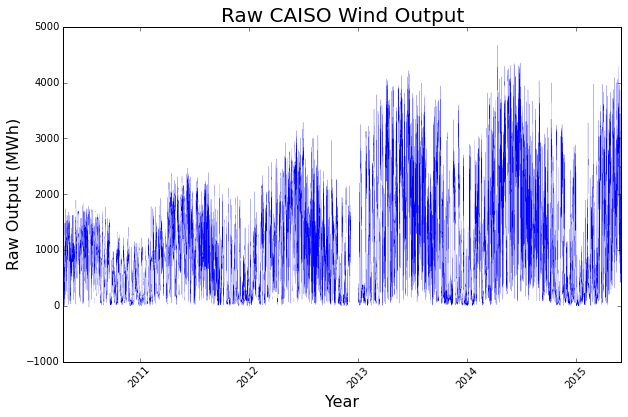

In [117]:
#Plot of all WindTotal data
lo = 0
hi = Data.WindOutput_MW.shape[0]

plt.figure(figsize=(10,6))
plt.title('Raw CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('Raw Output (MWh)', fontsize=16)

plt.plot(Data.index[lo:hi], Data.WindOutput_MW[lo:hi], 'b', linewidth = 0.15)

plt.show()

***Caption:*** The raw CAISO Wind Output trends upwards over time as CAISO adds capacity.

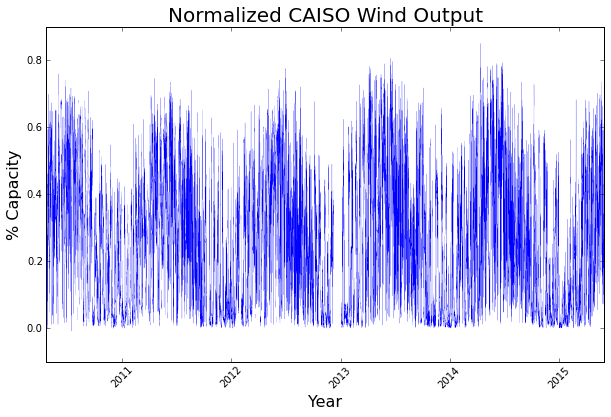

In [118]:
#Plot of all WindTotal data
lo = 0
hi = Data.P_Cap.shape[0]

plt.figure(figsize=(10,6))
plt.title('Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.P_Cap[lo:hi], 'b', linewidth = 0.15)

plt.show()

***Caption:*** The normalized output has daily and yearly cycles, but the overall upward trend is largely removed.

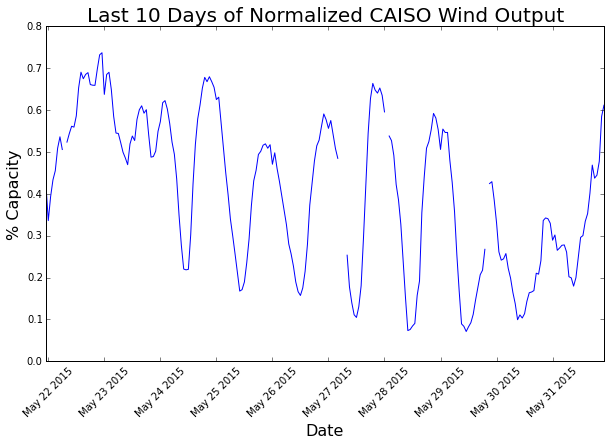

In [119]:
#Plot of all WindTotal data
lo = Data.P_Cap.shape[0]-240
hi = Data.P_Cap.shape[0]

plt.figure(figsize=(10,6))
plt.title('Last 10 Days of Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.P_Cap[lo:hi], 'b', linewidth = 1)
plt.show()

***Caption:*** This is a detailed look at the final 10 days of normalized wind generation.  At this scale the daily cycles are easy to recognize.  Gaps in the chart reflect data that are missing either from the CAISO dataset, or from the NOAA record.

#4.0 Modeling

I will use Random Forest algorithm because it can cope with the complex system interactions I expect are inherent in this prediction.  I also intend to include Support Vector Machines regression in the future.

##4.1 Target Variable and Model Data Split

I use the Patsy package to split Data into a Target variable (P_Cap) and a Model data frame.  The Model data frame contains all the variables that will be used by the Model_Complex approach, other Model dataframes are subsets of the Model dataframe.

In [120]:
#NA values are dropped for modeling.
Data = Data.dropna()

In [121]:
patsyString = 'P_Cap ~ 0 + PeriodicTime + Trail_1 + Trail_2 + Trail_3 + Trail_4 + C(CAMPO_Wind_Dir) +\
C(Livermore_Wind_Dir) + C(PSIA_Wind_Dir) +  C(Redding_Wind_Dir) + C(Tehachapi_Wind_Dir) + C(PortChicago_Wind_Dir) +\
CAMPO_Wind_Spd_Cubed + Livermore_Wind_Spd_Cubed + PSIA_Wind_Spd_Cubed + Redding_Wind_Spd_Cubed + Tehachapi_Wind_Spd_Cubed +\
PortChicago_Wind_Spd_Cubed + CAMPO_Gust_Spd_Cubed + Livermore_Gust_Spd_Cubed + PSIA_Gust_Spd_Cubed + Redding_Gust_Spd_Cubed +\
Tehachapi_Gust_Spd_Cubed + PortChicago_Gust_Spd_Cubed + CAMPO_Density + Livermore_Density + PSIA_Density + Redding_Density'

In [122]:
Target, Model = dmatrices(patsyString, Data, return_type='dataframe')

In [123]:
Model.head()

,C(CAMPO_Wind_Dir)[010],C(CAMPO_Wind_Dir)[020],C(CAMPO_Wind_Dir)[030],C(CAMPO_Wind_Dir)[040],C(CAMPO_Wind_Dir)[050],C(CAMPO_Wind_Dir)[060],C(CAMPO_Wind_Dir)[070],C(CAMPO_Wind_Dir)[080],C(CAMPO_Wind_Dir)[090],C(CAMPO_Wind_Dir)[100],...,CAMPO_Gust_Spd_Cubed,Livermore_Gust_Spd_Cubed,PSIA_Gust_Spd_Cubed,Redding_Gust_Spd_Cubed,Tehachapi_Gust_Spd_Cubed,PortChicago_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density,Redding_Density
2010-04-20 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,12167,0,0,0,1.127415,1.207839,1.156181,1.185945
2010-04-20 05:00:00,0,1,0,0,0,0,0,0,0,0,...,0,0,8000,0,0,0,1.136907,1.206606,1.160153,1.185949
2010-04-20 06:00:00,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1.136907,1.205979,1.162514,1.190194
2010-04-20 07:00:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1.143671,1.204994,1.164696,1.194066
2010-04-20 08:00:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1.143844,1.203976,1.173125,1.198861


##4.2 Random Forest Modeling

I have generated four separate models to test the effectiveness of inputing different variables into the algorithms.
- Model_Simple: Includes the 4 hours of trailing output data and nothing else.  
- Model_Simple_Periodic: 4 hours of triling output data plust the periodic_time variable.
- Model_NoWindDirec: All available variables excluding the wind direction classification at each NOAA site.
- Model_Complex: includes all available variables.

###4.2.1 Model Input Data

####4.2.1.1 Model_Simple

In [124]:
#Simple Model uses only the previous four hours of output to predict the next hour.
Model_Simple = pd.DataFrame([Model.Trail_1, Model.Trail_2, Model.Trail_3, Model.Trail_4]).transpose()
Model_Simple.head()

,Trail_1,Trail_2,Trail_3,Trail_4
2010-04-20 04:00:00,0.369558,0.271062,0.253045,0.253045
2010-04-20 05:00:00,0.350339,0.369558,0.271062,0.253045
2010-04-20 06:00:00,0.399587,0.350339,0.369558,0.271062
2010-04-20 07:00:00,0.305496,0.399587,0.350339,0.369558
2010-04-20 08:00:00,0.217811,0.305496,0.399587,0.350339


####4.2.1.2 Model_Simple_Periodic

In [125]:
Model_Simple_Periodic = pd.concat([Model_Simple, Model.PeriodicTime], axis = 1)
Model_Simple_Periodic.head()

,Trail_1,Trail_2,Trail_3,Trail_4,PeriodicTime
2010-04-20 04:00:00,0.369558,0.271062,0.253045,0.253045,0.737476
2010-04-20 05:00:00,0.350339,0.369558,0.271062,0.253045,0.737476
2010-04-20 06:00:00,0.399587,0.350339,0.369558,0.271062,0.737476
2010-04-20 07:00:00,0.305496,0.399587,0.350339,0.369558,0.737476
2010-04-20 08:00:00,0.217811,0.305496,0.399587,0.350339,0.737476


####4.2.1.3 Model_NoWindDir

In [126]:
Model_NoWindDir = Model.iloc[:,222:242]
Model_NoWindDir.head()

,PeriodicTime,Trail_1,Trail_2,Trail_3,Trail_4,CAMPO_Wind_Spd_Cubed,Livermore_Wind_Spd_Cubed,PSIA_Wind_Spd_Cubed,Redding_Wind_Spd_Cubed,Tehachapi_Wind_Spd_Cubed,PortChicago_Wind_Spd_Cubed,CAMPO_Gust_Spd_Cubed,Livermore_Gust_Spd_Cubed,PSIA_Gust_Spd_Cubed,Redding_Gust_Spd_Cubed,Tehachapi_Gust_Spd_Cubed,PortChicago_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density
2010-04-20 04:00:00,0.737476,0.369558,0.271062,0.253045,0.253045,0,0,4096,343,343,4913,0,0,12167,0,0,0,1.127415,1.207839,1.156181
2010-04-20 05:00:00,0.737476,0.350339,0.369558,0.271062,0.253045,125,1331,2197,729,0,343,0,0,8000,0,0,0,1.136907,1.206606,1.160153
2010-04-20 06:00:00,0.737476,0.399587,0.350339,0.369558,0.271062,125,1000,27,512,0,1,0,0,0,0,0,0,1.136907,1.205979,1.162514
2010-04-20 07:00:00,0.737476,0.305496,0.399587,0.350339,0.369558,125,216,1000,0,512,27,0,0,0,0,0,0,1.143671,1.204994,1.164696
2010-04-20 08:00:00,0.737476,0.217811,0.305496,0.399587,0.350339,27,512,343,729,125,8,0,0,0,0,0,0,1.143844,1.203976,1.173125


####4.2.1.4 Model_Complex

In [127]:
Model_Complex = Model
Model_Complex.head()

,C(CAMPO_Wind_Dir)[010],C(CAMPO_Wind_Dir)[020],C(CAMPO_Wind_Dir)[030],C(CAMPO_Wind_Dir)[040],C(CAMPO_Wind_Dir)[050],C(CAMPO_Wind_Dir)[060],C(CAMPO_Wind_Dir)[070],C(CAMPO_Wind_Dir)[080],C(CAMPO_Wind_Dir)[090],C(CAMPO_Wind_Dir)[100],...,CAMPO_Gust_Spd_Cubed,Livermore_Gust_Spd_Cubed,PSIA_Gust_Spd_Cubed,Redding_Gust_Spd_Cubed,Tehachapi_Gust_Spd_Cubed,PortChicago_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density,Redding_Density
2010-04-20 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,12167,0,0,0,1.127415,1.207839,1.156181,1.185945
2010-04-20 05:00:00,0,1,0,0,0,0,0,0,0,0,...,0,0,8000,0,0,0,1.136907,1.206606,1.160153,1.185949
2010-04-20 06:00:00,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1.136907,1.205979,1.162514,1.190194
2010-04-20 07:00:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1.143671,1.204994,1.164696,1.194066
2010-04-20 08:00:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1.143844,1.203976,1.173125,1.198861


##4.3 SVM Modeling

- To be added at a later time

##4.4 Train, CV, Test Split

The TrainTestCV_Split function splits each of the input data frames (modelData and targetVar) into three smaller data frames based on the percentages wished to be used for Training, Cross Validation, and Testing respectively.  By default 60% of the data are used for training, 20% are used for cross validation, and the final 20% can be used to test the model's predictive performance.  

It is important to note that in this custom function the data are not randomized prior to being split.  Instead they are split based on their arrangement in the input dataframes.  This custom splitting function was necessary because native scikit-learn packages randomize dataframes before splitting a dataset into train, test, cv subgroups, however timeseries data should not be randomized before being split.  In a timeseries application, earlier data should be used to explain later data, otherwise the algorithm may learn patterns that would not be available in a real-world setting.  Algorithms allowed to train on data collected later than the "prediction window" may artifically overperform during testing and development, and then underperform when applied in the real world.  This is why the split is performed sequentially.

In [128]:
#Simple train CV test split.  
#TrainPerc - percentage of data to be used for training.
#CVPerc
#TestPerc

def TrainTestCV_Split(modelData, targetVar, TrainPerc = 0.6, CVPerc = 0.2, TestPerc = 0.2):
    
    #error check:
    if TrainPerc+CVPerc+TestPerc != 1:
        print "Error: percentages must sum to unity."
        return None
    
    Train_Size = TrainPerc*modelData.shape[0]
    CV_Size = CVPerc*modelData.shape[0]
    Test_Size = TestPerc*modelData.shape[0]
    
    #Truncation of int forces conservative and non-overlapping subsetting.
    Train_ind = int(Train_Size)
    CV_ind = Train_ind + int(CV_Size)
    Test_ind = CV_ind + int(Test_Size)
    
    #
    Model_Train = modelData.iloc[0:int(Train_ind),:]
    Model_CV = modelData.iloc[int(Train_ind):int(CV_ind),:]
    Model_Test = modelData.iloc[int(CV_ind):int(Test_ind),:]
    Model_Train_CV = modelData.iloc[0:int(CV_ind),:]
    
    Target_Train = np.ravel(targetVar.iloc[0:int(Train_ind),:])
    Target_CV =  np.ravel(targetVar.iloc[int(Train_ind):int(CV_ind),:])
    Target_Test =  np.ravel(targetVar.iloc[int(CV_ind):int(Test_ind),:])
    Target_Train_CV =  np.ravel(targetVar.iloc[0:int(CV_ind),:])
    
    return (Model_Train, Model_CV, Model_Test, Model_Train_CV, 
            Target_Train, Target_CV, Target_Test, Target_Train_CV)

In [129]:
Simple_Tuple = TrainTestCV_Split(Model_Simple, Target)

Target_Train = Simple_Tuple[4]
Target_CV =  Simple_Tuple[5]
Target_Test =  Simple_Tuple[6]
Target_Train_CV =  Simple_Tuple[7]

Simple_Train = Simple_Tuple[0]
Simple_CV = Simple_Tuple[1]
Simple_Test = Simple_Tuple[2]
Simple_Train_CV = Simple_Tuple[3]

In [130]:
Simple_Periodic_Tuple = TrainTestCV_Split(Model_Simple_Periodic, Target)

Simple_Periodic_Train = Simple_Periodic_Tuple[0]
Simple_Periodic_CV = Simple_Periodic_Tuple[1]
Simple_Periodic_Test = Simple_Periodic_Tuple[2]
Simple_Periodic_Train_CV = Simple_Periodic_Tuple[3]

In [131]:
NoWindDir_Tuple = TrainTestCV_Split(Model_NoWindDir, Target)

NoWindDir_Train = NoWindDir_Tuple[0]
NoWindDir_CV = NoWindDir_Tuple[1]
NoWindDir_Test = NoWindDir_Tuple[2]
NoWindDir_Train_CV = NoWindDir_Tuple[3]

In [132]:
Complex_Tuple = TrainTestCV_Split(Model_Complex, Target)

Complex_Train = Complex_Tuple[0]
Complex_CV = Complex_Tuple[1]
Complex_Test = Complex_Tuple[2]
Complex_Train_CV = Complex_Tuple[3]

##4.5 Model Scoring

The model is scored based on Mean Square Error of the prediction.  I chose the mean squared error because it both minimizes the average error magnitude, and especially punishes particularly high errors.  The electrical grid always maintains some small amount of buffer supply, so that if estimates of demand are unusually low the grid will not experience blackouts or brownouts.  In this case unacceptably poor estimates of the output from wind farms will have a similar effect.  The average error should be minimized, but small errors in prediction are generally understood as  acceptable and normal.  Exceptional errors over short time periods are much less acceptable than small errors over long time periods.  The Mean Square Error punishes large erros over small time periods to a greater extent than small errors over long time periods, which would be identical to an error metric like the Mean Absolute Error.

In [133]:
#Custom scorer for GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better = False) 

In [134]:
#Custom Test, CV split.
PDS_TEST = np.array([-1] * Simple_Train.shape[0])
PDS_CV = np.array([0] * Simple_CV.shape[0])
PDS_Array = np.concatenate([PDS_TEST, PDS_CV], axis = 0)

preDefSpl = PredefinedSplit(PDS_Array)

#5.0 Model Execution

##5.1 Random Forest Gridsearch

In [165]:
#Paramatarization of gridsearch.

rfParameters = {'max_features' : ('log2', 'sqrt'), 'n_estimators' : range(20,500)}
rf = RandomForestRegressor()
rfGsearch = GridSearchCV(rf, rfParameters, scoring = scorer, cv = preDefSpl, n_jobs = -1)

###5.1.1 Simple_Model Gridsearch

In [137]:
%%time

rfGsearch.fit(Simple_Train_CV, Target_Train_CV)
print rfGsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 304}
CPU times: user 23.9 s, sys: 570 ms, total: 24.5 s
Wall time: 1min 14s


In [138]:
rf_Simple = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_Simple.fit(Simple_Train, Target_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=304, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [139]:
Result_rfSimple = rf_Simple.predict(Simple_Test)

Result_rfSimple_DataFrame = pd.DataFrame(Result_rfSimple, columns = ['Predict'], index = Simple_Test.index)
Result_rfSimple_DataFrame['Actual'] = Target_Test
Result_rfSimple_DataFrame['Difference'] = Result_rfSimple_DataFrame['Predict'] - Result_rfSimple_DataFrame['Actual']

Result_rfSimple_DataFrame.sample(5)

,Predict,Actual,Difference
2014-06-17 07:00:00,0.438226,0.420299,0.017927
2014-10-13 07:00:00,0.033264,0.027680,0.005584
2014-12-28 08:00:00,0.036585,0.015843,0.020742
2015-01-19 02:00:00,0.139023,0.111200,0.027823
2014-07-25 16:00:00,0.170709,0.185747,-0.015039


In [140]:
SqDiff_Simple = Result_rfSimple_DataFrame.Difference**2
np.sqrt(sum(SqDiff_Simple))

3.1266665656744346

In [142]:
Result_rfSimple_DataFrame.to_csv('data/results/rfSimple_Result.csv')

###5.1.2 Simple_Periodic_Model Gridsearch

In [144]:
%%time

rfGsearch.fit(Simple_Periodic_Train_CV, Target_Train_CV)
print rfGsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 389}
CPU times: user 35 s, sys: 3.3 s, total: 38.3 s
Wall time: 50min 51s


In [145]:
rf_Simple_Periodic = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_Simple_Periodic.fit(Simple_Periodic_Train, Target_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=389, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [146]:
Result_rfSimple_Periodic = rf_Simple_Periodic.predict(Simple_Periodic_Test)

Result_rfSimple_Periodic_DataFrame = pd.DataFrame(Result_rfSimple_Periodic, columns = ['Predict'], index = Simple_Periodic_Test.index)
Result_rfSimple_Periodic_DataFrame['Actual'] = Target_Test
Result_rfSimple_Periodic_DataFrame['Difference'] = Result_rfSimple_Periodic_DataFrame['Predict'] - Result_rfSimple_Periodic_DataFrame['Actual']

Result_rfSimple_Periodic_DataFrame.sample(5)

,Predict,Actual,Difference
2015-05-12 07:00:00,0.347364,0.317521,0.029842
2015-02-13 12:00:00,0.036833,0.034308,0.002525
2014-12-27 08:00:00,0.073962,0.058638,0.015324
2015-04-09 12:00:00,0.137747,0.088000,0.049747
2015-04-20 03:00:00,0.427549,0.413241,0.014308


In [147]:
SqDiff_Simple_Periodic = Result_rfSimple_Periodic_DataFrame.Difference**2
np.sqrt(sum(SqDiff_Simple_Periodic))

3.0661661691564106

In [148]:
Result_rfSimple_Periodic_DataFrame.to_csv('data/results/rfSimple_Periodic_Result.csv')

###5.1.3 NoWindDir_Model Gridsearch

In [149]:
%%time

rfGsearch.fit(NoWindDir_Train_CV, Target_Train_CV)
print rfGsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 449}
CPU times: user 1min 4s, sys: 6.58 s, total: 1min 11s
Wall time: 1h 2min 54s


In [150]:
rf_NoWindDir = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_NoWindDir.fit(NoWindDir_Train, Target_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=449, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [152]:
NoWindDir_Test.head()

,PeriodicTime,Trail_1,Trail_2,Trail_3,Trail_4,CAMPO_Wind_Spd_Cubed,Livermore_Wind_Spd_Cubed,PSIA_Wind_Spd_Cubed,Redding_Wind_Spd_Cubed,Tehachapi_Wind_Spd_Cubed,PortChicago_Wind_Spd_Cubed,CAMPO_Gust_Spd_Cubed,Livermore_Gust_Spd_Cubed,PSIA_Gust_Spd_Cubed,Redding_Gust_Spd_Cubed,Tehachapi_Gust_Spd_Cubed,PortChicago_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density
2014-06-16 06:00:00,0.998501,0.558881,0.554510,0.550686,0.550686,512,216,4913,343,2744,4096,0,0,21952,0,0,0,1.129830,1.205862,1.149069
2014-06-16 07:00:00,0.998501,0.551233,0.558881,0.554510,0.550686,125,1331,729,343,4096,10648,0,0,0,0,9261,0,1.141099,1.205375,1.149017
2014-06-16 08:00:00,0.998501,0.520093,0.551233,0.558881,0.554510,216,1331,512,0,4096,4096,0,0,0,0,0,0,1.141201,1.207718,1.149017
2014-06-16 09:00:00,0.998501,0.482761,0.520093,0.551233,0.558881,343,2197,125,216,4096,5832,0,0,0,0,0,0,1.145466,1.207718,1.154996
2014-06-16 10:00:00,0.998501,0.439056,0.482761,0.520093,0.551233,343,729,512,0,5832,2197,0,0,0,0,12167,0,1.145840,1.205862,1.153152


In [153]:
Result_rfNoWindDir = rf_NoWindDir.predict(NoWindDir_Test)

Result_rfNoWindDir_DataFrame = pd.DataFrame(Result_rfNoWindDir, columns = ['Predict'], index = NoWindDir_Test.index)
Result_rfNoWindDir_DataFrame['Actual'] = Target_Test
Result_rfNoWindDir_DataFrame['Difference'] = Result_rfNoWindDir_DataFrame['Predict'] - Result_rfNoWindDir_DataFrame['Actual']

Result_rfNoWindDir_DataFrame.sample(5)

,Predict,Actual,Difference
2015-01-05 16:00:00,0.019200,0.020107,-0.000907
2015-05-13 10:00:00,0.305418,0.290933,0.014485
2014-12-01 15:00:00,0.023896,0.024402,-0.000506
2015-02-17 09:00:00,0.114058,0.121794,-0.007736
2014-12-26 09:00:00,0.194499,0.209967,-0.015468


In [155]:
SqDiff_NoWindDir = Result_rfNoWindDir_DataFrame.Difference**2
np.sqrt(sum(SqDiff_NoWindDir))

3.2375127169980069

In [157]:
Result_rfNoWindDir_DataFrame.to_csv('data/results/rfNoWindDir_Result.csv')

###5.1.4 Complex_Model Gridsearch

In [159]:
%%time

#The Train_CV split has been entered into the rfGridsearch function as cv = preDefSpl defined
#above.

rfGsearch.fit(Complex_Train_CV, Target_Train_CV)
print rfGsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 101}
CPU times: user 13.5 s, sys: 1.07 s, total: 14.6 s
Wall time: 32 s


In [160]:
rf_Complex = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_Complex.fit(Complex_Train, Target_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=101, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [161]:
Result_rfComplex = rf_Complex.predict(Complex_Test)

Result_rfComplex_DataFrame = pd.DataFrame(Result_rfComplex, columns = ['Predict'], index = Complex_Test.index)
Result_rfComplex_DataFrame['Actual'] = Target_Test
Result_rfComplex_DataFrame['Difference'] = Result_rfComplex_DataFrame['Predict'] - Result_rfComplex_DataFrame['Actual']

Result_rfComplex_DataFrame.sample(5)

,Predict,Actual,Difference
2014-11-09 05:00:00,0.012997,0.006009,0.006987
2014-09-19 12:00:00,0.154712,0.114362,0.040350
2015-02-14 06:00:00,0.035920,0.022986,0.012934
2014-09-21 01:00:00,0.436476,0.422484,0.013992
2015-01-14 18:00:00,0.012979,0.003953,0.009026


In [162]:
SqDiff_Complex = Result_rfComplex_DataFrame.Difference**2
np.sqrt(sum(SqDiff_Complex))

4.2172229599618607

In [164]:
Result_rfComplex_DataFrame.to_csv('data/results/rfComplex_Result.csv')

#Import Results Directly

Running the random forest algorithms in order to generate the models through each iteration takes several hours on a medium-quality machine, so the resulting predictions have been saved as .csv files under the data/results directory:

- rfSimple_Result.csv
- rfSimple_Periodic_Result.csv
- rfNoWindDir_Result.csv
- rfComplex_Result.csv

These files can be directly accessed with the code below without the need to rerun the time-consuming modeling code.

In [234]:
#For each model, the data are loaded, indexed to the first column, and then reindexed so that the index is continuious
Result_rfSimple_DataFrame = pd.read_csv('data/results/rfSimple_Result.csv', index_col = 0)
Result_rfSimple_DataFrame.index = pd.to_datetime(Result_rfSimple_DataFrame.index)
Result_rfSimple_DataFrame = Result_rfSimple_DataFrame.reindex(pd.date_range('6/16/2014 6:00:00', periods=8391, freq='H'))

Result_rfSimple_Periodic_DataFrame = pd.read_csv('data/results/rfSimple_Periodic_Result.csv', index_col = 0)
Result_rfSimple_Periodic_DataFrame.index = pd.to_datetime(Result_rfSimple_Periodic_DataFrame.index)
Result_rfSimple_Periodic_DataFrame = Result_rfSimple_Periodic_DataFrame.reindex(pd.date_range('6/16/2014 6:00:00', periods=8391, freq='H'))

Result_rfNoWindDir_DataFrame = pd.read_csv('data/results/rfNoWindDir_Result.csv', index_col = 0)
Result_rfNoWindDir_DataFrame.index = pd.to_datetime(Result_rfNoWindDir_DataFrame.index)
Result_rfNoWindDir_DataFrame = Result_rfNoWindDir_DataFrame.reindex(pd.date_range('6/16/2014 6:00:00', periods=8391, freq='H'))

Result_rfComplex_DataFrame = pd.read_csv('data/results/rfComplex_Result.csv', index_col = 0)
Result_rfComplex_DataFrame.index = pd.to_datetime(Result_rfComplex_DataFrame.index)
Result_rfComplex_DataFrame = Result_rfComplex_DataFrame.reindex(pd.date_range('6/16/2014 6:00:00', periods=8391, freq='H'))

#6.0 Results

In [235]:
rfSimple_stDev = np.std(Result_rfSimple_DataFrame.Difference)
rfSimple_Periodic_stDev = np.std(Result_rfSimple_Periodic_DataFrame.Difference)
rfNoWindDir_stDev = np.std(Result_rfNoWindDir_DataFrame.Difference)
rfComplex_stDev = np.std(Result_rfComplex_DataFrame.Difference)

StDev_df = pd.DataFrame([rfSimple_stDev, rfSimple_Periodic_stDev, rfNoWindDir_stDev, rfComplex_stDev],
                         index = ['Simple','Simple_Periodic','NoWindDir','Complex'], columns = ['StDev'])

In [236]:
StDev_df

,StDev
Simple,0.035357
Simple_Periodic,0.034687
NoWindDir,0.036572
Complex,0.047560


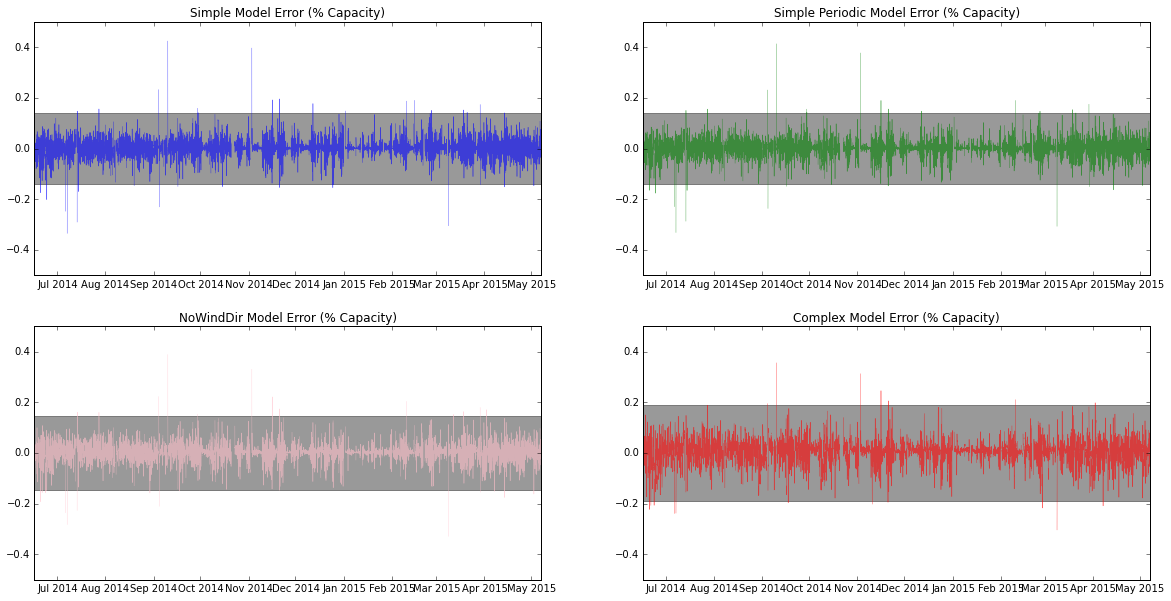

In [237]:
#for ind in anomalies_rfComplex.index:
f, axarr = plt.subplots(2,2)
f.set_figheight(10)
f.set_figwidth(20)
anomalyDegree = 4 # Number of standard deviations covered by gray bands

yScaleMin = -0.5
yScaleMax = 0.5

lo = 0
hi = int(Target_Test.shape[0])

axarr[0,0].plot(Result_rfSimple_DataFrame[lo:hi].index, Result_rfSimple_DataFrame.Difference[lo:hi], 
         'b', linewidth = 0.5, alpha = 0.6)
axarr[0,0].axhspan(anomalyDegree*rfSimple_stDev, -anomalyDegree*rfSimple_stDev, facecolor='k', alpha=0.4)
axarr[0,0].set_title("Simple Model Error (% Capacity)")
axarr[0,0].set_ylim([yScaleMin,yScaleMax])

axarr[0,1].plot(Result_rfSimple_Periodic_DataFrame[lo:hi].index, Result_rfSimple_Periodic_DataFrame.Difference[lo:hi], 
         'g', linewidth = 0.5, alpha = 0.6)
axarr[0,1].axhspan(anomalyDegree*rfSimple_Periodic_stDev, -anomalyDegree*rfSimple_Periodic_stDev, facecolor='k', alpha=0.4)
axarr[0,1].set_title("Simple Periodic Model Error (% Capacity)")
axarr[0,1].set_ylim([yScaleMin,yScaleMax])

axarr[1,0].plot(Result_rfNoWindDir_DataFrame[lo:hi].index, Result_rfNoWindDir_DataFrame.Difference[lo:hi], 
         'pink', linewidth = 0.5, alpha = 0.6)
axarr[1,0].axhspan(anomalyDegree*rfNoWindDir_stDev, -anomalyDegree*rfNoWindDir_stDev, facecolor='k', alpha=0.4)
axarr[1,0].set_title("NoWindDir Model Error (% Capacity)")
axarr[1,0].set_ylim([yScaleMin,yScaleMax])

axarr[1,1].plot(Result_rfComplex_DataFrame[lo:hi].index, Result_rfComplex_DataFrame.Difference[lo:hi], 
         'r', linewidth = 0.5, alpha = 0.6)
axarr[1,1].axhspan(anomalyDegree*rfComplex_stDev, -anomalyDegree*rfComplex_stDev, facecolor='k', alpha=0.4)
axarr[1,1].set_title("Complex Model Error (% Capacity)")
axarr[1,1].set_ylim([yScaleMin,yScaleMax])

plt.show()

**Caption:** This chart shows that the simple and complex model error, i.e. the difference between the predicted output and the actual system output, is not stochastic.  The chart displays all 8,606 predictions for both of the Random Forest models, the simple model in blue and the complex model in red.  The gray shaded ares is the area +/- 4 standard deviations (light gray for complex model, dark gray for simple model) away from the actual system output.  This specific range is shown because were the system stochastic, we would expect to see approximately one prediction outside of the shaded box for each of the models (1 observation in 8,609 should exceed 3.681 sd).  The complex model shows slightly more variability than the simple model (sd_rfComplex = 0.0381, sd_rfSimple = 0.0344) The grey shaded area shows +/- 3.681 standard deviations from the actual value.  It is obvious from this chart that many more outliers exist than would be expected from simple variability for both models.  

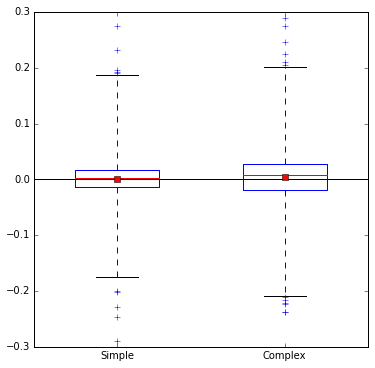

In [207]:
lo = 0
hi = int(Result_rfComplex_DataFrame.dropna().shape[0])

fig, ax1 = plt.subplots(figsize=(6,6))
plt.axhline(color = 'k')
boxPlotData = [Result_rfSimple_DataFrame.Difference[lo:hi].dropna(), 
               Result_rfComplex_DataFrame.Difference[lo:hi].dropna()]

pylab.boxplot(boxPlotData, whis = [0.1,99.9], widths=0.5, showmeans=True)
pylab.xticks([1,2], ["Simple", 'Complex'])
pylab.ylim([-0.3,0.3])

plt.show()

***Caption:*** Boxplot showing the errors of the Simple and complex models.  Whiskers are at 0.1 and 99.9 percentiles.  There is good agreement of the mean (red dots) and the median (red line) in both models.  The Simple model has slightly better fidelity to the actual output, easily seen by the slimmer box and slightly higher 0.1 percentile whisker.

In [192]:
anomalyDegree = 4

anomalies_rfComplex = abs(Result_rfComplex_DataFrame.Difference) > anomalyDegree*rfComplex_stDev
anomalies_rfSimple = abs(Result_rfSimple_DataFrame.Difference) > anomalyDegree*rfSimple_stDev

numAnomaly_rfComplex =sum(anomalies_rfComplex)
numAnomaly_rfSimple =sum(anomalies_rfSimple)
print numAnomaly_rfComplex, numAnomaly_rfSimple

27 40


In [193]:
anomalies_rfComplex = pd.DataFrame([anomalies_rfComplex[anomalies_rfComplex == True]]).transpose()
anomalies_rfSimple = pd.DataFrame([anomalies_rfSimple[anomalies_rfSimple == True]]).transpose()
anomalies_rfComplex.columns = ['Anomaly_T']
anomalies_rfSimple.columns = ['Anomaly_T']

In [194]:
anomalies_rfComplex

,Anomaly_T
2014-06-20 13:00:00,True
2014-06-20 14:00:00,True
2014-06-21 14:00:00,True
2014-06-23 15:00:00,True
2014-06-23 16:00:00,True
2014-07-06 17:00:00,True
2014-07-07 16:00:00,True
2014-07-12 23:00:00,True
2014-08-07 09:00:00,True
2014-08-07 11:00:00,True


In [250]:
pd.to_datetime('2014/07/12, 23:00:00')

Timestamp('2014-07-12 23:00:00')

In [254]:
Data.loc[pd.to_datetime('7/12/2014 08:00:00'): pd.to_datetime('7/13/2014 12:00:00')]

,CAISO_WindCapacity,WindOutput_MW,CAMPO_ActualTime,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,...,Tehachapi_Gust_Spd_Cubed,CAMPO_Density,Livermore_Density,PSIA_Density,Redding_Density,Trail_1,Trail_2,Trail_3,Trail_4,PeriodicTime
2014-07-12 08:00:00,5491.33,1706,2014-07-12 08:52:00,No_Wind,0,0,56,50,1013.0,923.8,...,0,1.117736,1.203932,1.135252,1.159463,0.409737,0.443244,0.538667,0.576909,0.966145
2014-07-12 09:00:00,5491.33,1145,2014-07-12 09:52:00,050,5,0,55,50,1012.7,923.5,...,0,1.119542,1.203932,1.136988,1.170272,0.310672,0.409737,0.443244,0.538667,0.966145
2014-07-12 10:00:00,5491.33,723,2014-07-12 10:52:00,040,5,0,54,49,1012.9,923.5,...,0,1.121929,1.201018,1.139212,1.175164,0.208511,0.310672,0.409737,0.443244,0.966145
2014-07-12 11:00:00,5491.33,566,2014-07-12 11:52:00,050,6,0,54,49,1013.1,923.5,...,0,1.121929,1.201379,1.141862,1.182215,0.131662,0.208511,0.310672,0.409737,0.966145
2014-07-12 12:00:00,5491.33,557,2014-07-12 12:52:00,060,6,0,51,48,1013.7,924.1,...,0,1.129459,1.204294,1.146238,1.189802,0.103072,0.131662,0.208511,0.310672,0.966145
2014-07-12 23:00:00,5491.33,3417,2014-07-12 23:52:00,260,8,0,87,55,1011.2,922.3,...,9261,1.051560,1.155076,1.096035,1.103034,0.101433,0.103072,0.131662,0.208511,0.966145
2014-07-13 01:00:00,5491.33,2928,2014-07-13 01:52:00,220,14,0,77,57,1011.9,922.6,...,9261,1.071012,1.176377,1.099513,1.112654,0.622254,0.101433,0.103072,0.131662,0.962962
2014-07-13 02:00:00,5491.33,2894,2014-07-13 02:52:00,210,9,0,72,56,1011.9,922.6,...,5832,1.081334,1.185668,1.106355,1.122601,0.533204,0.622254,0.101433,0.103072,0.962962
2014-07-13 03:00:00,5491.33,2742,2014-07-13 03:52:00,220,5,0,69,56,1012.0,922.9,...,0,1.087826,1.198114,1.114768,1.127726,0.527013,0.533204,0.622254,0.101433,0.962962
2014-07-13 04:00:00,5491.33,2475,2014-07-13 04:52:00,No_Wind,0,0,67,55,1012.3,923.2,...,0,1.092559,1.203570,1.119474,1.141077,0.499333,0.527013,0.533204,0.622254,0.962962


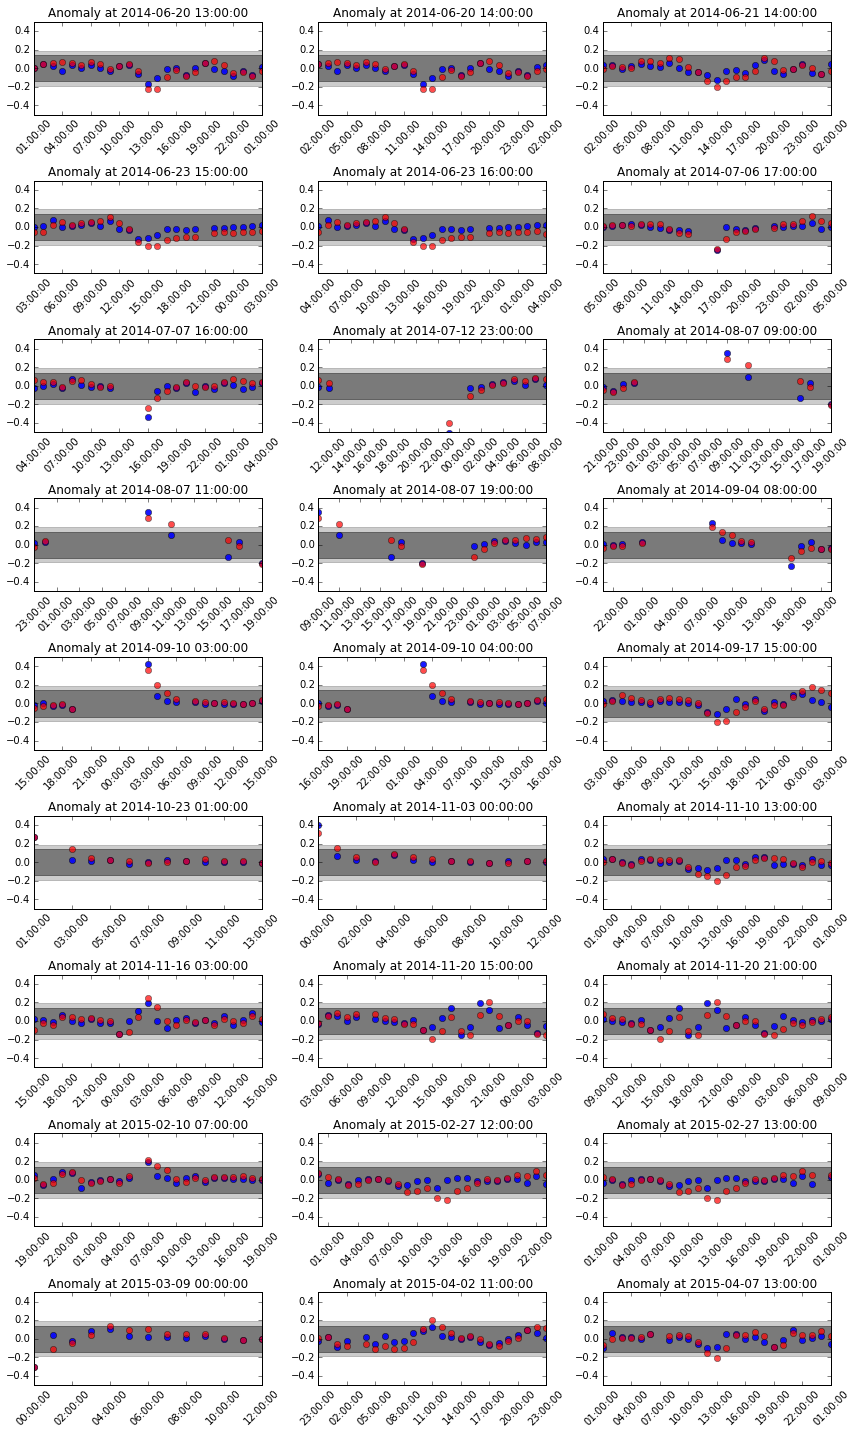

In [239]:
#for ind in anomalies_rfComplex.index:
numplots_y = 9
numplots_x = 3

f, axarr = plt.subplots(numplots_y,numplots_x)
f.set_figheight(20)
f.set_figwidth(12)

anomalyDegree = 4

index = 0

for i in range(0,numplots_y):
    for j in range(0,numplots_x):
        ind = anomalies_rfComplex.index[index]
        lo = ind-pd.DateOffset(hours=12)
        hi = ind+pd.DateOffset(hours=12)

        axarr[i,j].plot(Result_rfSimple_DataFrame[lo:hi].index, Result_rfSimple_DataFrame.Difference[lo:hi], 
                 'bo', linewidth = 0.5, alpha = 0.9)
        axarr[i,j].plot(Result_rfComplex_DataFrame[lo:hi].index, Result_rfComplex_DataFrame.Difference[lo:hi], 
                 'ro', linewidth = 0.5, alpha = 0.7)
        
        axarr[i,j].axhspan(anomalyDegree*rfSimple_stDev, -anomalyDegree*rfSimple_stDev, facecolor='k', alpha=0.4)
        axarr[i,j].axhspan(anomalyDegree*rfComplex_stDev, -anomalyDegree*rfComplex_stDev, facecolor='k', alpha=0.2)
        
        axarr[i,j].set_title("Anomaly at " + str(anomalies_rfComplex.index[index]))
        axarr[i,j].set_ylim([-0.5,0.5])

        index += 1
        
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
f.tight_layout()

In [ ]:
#MSW of Simple Model
MSE_rfSimple = mean_squared_error(100*Result_rfSimple_DataFrame.Predict.dropna(), 100*Result_rfSimple_DataFrame.Actual.dropna())

In [ ]:
#MSA of Complex Model
MSE_rfComplex = mean_squared_error(100*Result_rfComplex_DataFrame.Predict.dropna(), 100*Result_rfComplex_DataFrame.Actual.dropna())

In [ ]:
print[MSE_rfSimple, MSE_rfComplex]

The model that includes the time of year in the model significantly outperforms the simple model that does not.

In [ ]:
#Final 10 days of modeling
#for ind in anomalies_rfComplex.index:
lo = 0
hi = Result_rfSimple_DataFrame.Predict.shape[0]

f, axarr = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)

yScaleMin = -0.7
yScaleMax = 0.7

axarr[0].plot(Result_rfSimple_DataFrame.index[hi-240:hi], 
              Result_rfSimple_DataFrame.Predict[hi-240:hi], 'b', linewidth = 4)
axarr[0].plot(Result_rfSimple_DataFrame.index[hi-240:hi], 
              Result_rfSimple_DataFrame.Actual[hi-240:hi], 'r', linewidth = 2)

axarr[1].plot(Result_rfComplex_DataFrame.index[hi-240:hi], 
              Result_rfComplex_DataFrame.Predict[hi-240:hi], 'b', linewidth = 4)
axarr[1].plot(Result_rfComplex_DataFrame.index[hi-240:hi], 
              Result_rfComplex_DataFrame.Actual[hi-240:hi], 'r', linewidth = 2)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.show()

###4.1 Feature Importance

In [ ]:
importance_Simple = pd.DataFrame({'importance': rf_Simple.feature_importances_}, 
                                  index=X_Simple_Test.columns).sort('importance')

importance_Complex = pd.DataFrame({'importance': rf_Complex.feature_importances_}, 
                                  index=X_Complex_Test.columns).sort('importance')

In [ ]:
importance_Complex.plot(kind = 'bar')
importance_Simple.plot(kind = 'bar')

plt.show()

***Caption:*** Feature importance of the complex and the simple models.  The simple model puts relatively more importance on the first hour (not difference in scale).  Both models have hourly data in the correct order, meaning that data from four hours ago is less important than that from three hours ago, etc.

##5.0 Conclusions

In [ ]:
print MSE_rfSimple, np.sqrt(MSE_rfSimple)

In [ ]:
print MSE_rfComplex, np.sqrt(MSE_rfComplex)

The complex model, which includes data about the time of the year outperforms the simple model slightly, but only slightly.  This makes sense intuitively because the data have strong annual cycle.  I will continue to improve this model, and also include analysis by SVM.